Ce calepin regroupe différentes manips qui ont abouti en partie à [une cartographie (la plus exhaustive possible) des candidats](https://www.rue89strasbourg.com/departementales-2021-alsace-candidats-carte-208516) **aux élections départementales 2021 en Alsace**.

![carte_cantonales](carte_candidats_can021.png)

Il comprend notamment :
* **la préparation de fonds de cartes** (contours départementaux et villes principales)
* diverses jointures entre une **base de données très basique, et une enrichie**. La première résulte **d'une aspiration des listes** fournies par le Ministère de l'Intérieur, la seconde des réponses à un formulaire envoyés par de nombreux candidats aux départementales. Ces réponses **ont été rassemblées par les camarades de Rue89 Strasbourg** dans un tableur Google

Ce contexte posé, on va peut invoquer quelques modules de ma sélection habituelle consacrée à la géographie :

In [23]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geocoder, requests, csv
import osmnx as ox
import seaborn as sns
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
from bs4 import BeautifulSoup

# Préparer les fichiers géographiques

On va très rapidement formater les différents fichiers géographiques nécessaires à la carte. Il y aura :

* **des lignes**, avec les départements alsaciens. Cela va se faire avec ce [fichier fourni par OpenStreetMap](https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/)
* **des points**, avec quelques villes repères de la région. Cette fois-ci, [cet autre fichier d'OSM](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/) sera appelé
* **des polygones**, avec... les cantons départementaux. [Ce dernier fichier](https://www.data.gouv.fr/fr/datasets/contours-des-cantons-electoraux-departementaux-2015/) sera cette fois fourni par le Ministère de l'Intérieur

J'ai téléchargé chacun des fichiers en local, mais selon leur accessibilité en ligne, on peut aussi directement les lire via geopandas.

## Côté départements

La première manip coule d'elle-même : **créer une GeoDataFrame à partir du fichier** !

In [24]:
dept = gpd.read_file(r"C:\Users\Rapha\Documents\Data\Geographie\France\Départements\Contours\departements-20180101.shp")
dept.head()

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
0,974,La Réunion,FR940,fr:La Réunion,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,11,Aude,FR811,fr:Aude (département),6343.0,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,43,Haute-Loire,FR723,fr:Haute-Loire,5003.0,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,13,Bouches-du-Rhône,FR823,fr:Bouches-du-Rhône,5247.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,47,Lot-et-Garonne,FR614,fr:Lot-et-Garonne,5385.0,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."


On va ensuite :

* virer les colonnes inutiles 
* ne retenir que les départements alsaciens
* transformer les polygones en lignes

Cela se fait en deux lignes de code :

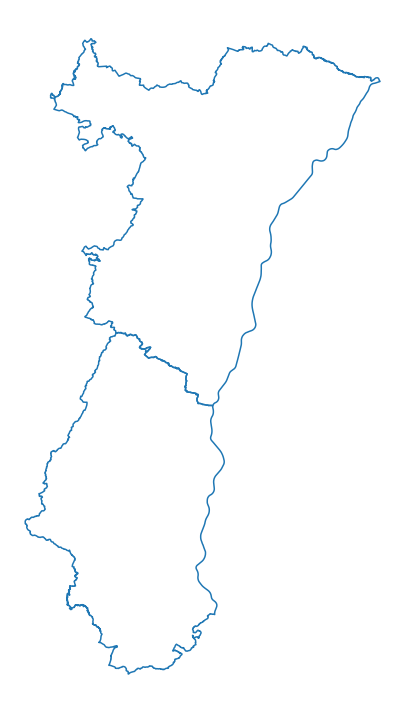

In [25]:
dept.drop(["nom","nuts3","wikipedia","surf_km2"], axis=1, inplace=True)
dept= dept[dept["code_insee"].isin(["67","68"])].boundary

fig,ax=plt.subplots(figsize=(7,14))

dept.plot(ax=ax)
ax.axis("off");

Le résultat est parfaitement conforme, et la GDF peut être transformée en json !

In [26]:
dept.to_file("data/depts.json", driver="GeoJSON")

## Côté villes

Comme avant, on va d'abord charger une nouvelle GDF :

In [27]:
com = gpd.read_file(r"C:\Users\Rapha\Documents\Data\Geographie\France\Communes\Contours\communes-20210101.shp")
com.head()

,insee,nom,wikipedia,surf_ha,geometry
0,30225,Sabran,fr:Sabran (Gard),3563.0,"POLYGON ((4.49703 44.14344, 4.49727 44.14398, ..."
1,26334,Salettes,fr:Salettes (Drôme),706.0,"POLYGON ((4.94213 44.57481, 4.94283 44.57501, ..."
2,04200,Salignac,fr:Salignac (Alpes-de-Haute-Provence),1435.0,"POLYGON ((5.95337 44.15613, 5.95341 44.15649, ..."
3,04179,Saint-Geniez,fr:Saint-Geniez,3900.0,"POLYGON ((5.98593 44.23280, 5.98654 44.23292, ..."
4,05162,La Saulce,fr:La Saulce,771.0,"POLYGON ((5.98920 44.41892, 5.98921 44.41894, ..."


Dans [D3js](https://d3js.org/), la bibliothèque de visualisation utilisée pour le rendu final, le mieux est d'avoir une doublette composée **d'un nom et d'un couple latitude-longitude**.

Cela va se régler facilement en :
* annonçant une liste de villes pour filtrer la grosse GDF
* transformant ces polygones en points via **[la fonction centroid](https://geopandas.org/docs/user_guide/geometric_manipulations.html#GeoSeries.centroid)** (qui calcule grosso modo [le barycentre d'un polygone](https://fr.wikipedia.org/wiki/Barycentre))

In [28]:
l_villes=["Strasbourg","Mulhouse","Colmar","Guebwiller","Altkirch","Thann","Sélestat","Molsheim","Saverne","Haguenau","Wissembourg"]
com = com[com["nom"].isin(l_villes)].copy().reset_index()
com = com[["nom","geometry"]]
com["geometry"]=com["geometry"].centroid
com

<ipython-input-28-089c166f0579>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  com["geometry"]=com["geometry"].centroid


,nom,geometry
0,Guebwiller,POINT (7.21025 47.90968)
1,Molsheim,POINT (7.49996 48.54446)
2,Strasbourg,POINT (7.76776 48.57125)
3,Saverne,POINT (7.34225 48.73957)
4,Thann,POINT (7.09464 47.81407)
5,Wissembourg,POINT (7.96211 49.01857)
6,Colmar,POINT (7.38489 48.10995)
7,Sélestat,POINT (7.46215 48.24810)
8,Haguenau,POINT (7.83060 48.84198)
9,Altkirch,POINT (7.24459 47.62105)


C'est conforme, et part donc en fichier json.

In [29]:
com.to_file("data/villes.json", driver="GeoJSON")

## Côté cantons

Vous connaissez désormais la musique : le premier couplet annonce toujours l'arrivée d'une GeoDataFrame.

In [30]:
GDF = gpd.read_file(r"C:\Users\Rapha\Documents\Data\Geographie\France\Circo\Dép\2015\Cantons_2015_WGS4G.shp")
GDF.head()

,ID_CAN,NOM_CAN,CODE_CAN,CODE_DEP,geometry
0,97119,Sainte-Rose-2,19,971,"POLYGON ((-61.71704 16.34309, -61.71714 16.342..."
1,97114,Petit-Canal,14,971,"POLYGON ((-61.53571 16.45294, -61.53565 16.454..."
2,97109,Lamentin,09,971,"POLYGON ((-61.64843 16.21296, -61.64899 16.212..."
3,97113,Petit-Bourg,13,971,"MULTIPOLYGON (((-61.66097 16.09379, -61.66177 ..."
4,97102,Les Abymes-2,02,971,"POLYGON ((-61.49111 16.30373, -61.49110 16.304..."


Et ensuite, dans ce cas précis :
* on applique un filtre départemental
* on supprimer les colonnes inutiles
* on renomme ce qui reste

In [31]:
alsace = GDF[GDF["CODE_DEP"].isin(["67","68"])].copy().reset_index()
alsace.drop(["index", "CODE_CAN","CODE_DEP"],axis=1, inplace=True)
alsace.rename(columns={"ID_CAN":"id","NOM_CAN":"nom"}, inplace=True)
alsace.head()

,id,nom,geometry
0,6716,Sélestat,"POLYGON ((7.47694 48.20353, 7.47648 48.20364, ..."
1,6719,Strasbourg-3,"POLYGON ((7.68805 48.59813, 7.68795 48.59905, ..."
2,6717,Strasbourg-1,"POLYGON ((7.74370 48.58537, 7.74604 48.58658, ..."
3,6709,Lingolsheim,"POLYGON ((7.60233 48.55339, 7.60115 48.55327, ..."
4,6702,Bouxwiller,"POLYGON ((7.51059 48.74402, 7.51031 48.74394, ..."


Ce qui donne, visualisé :

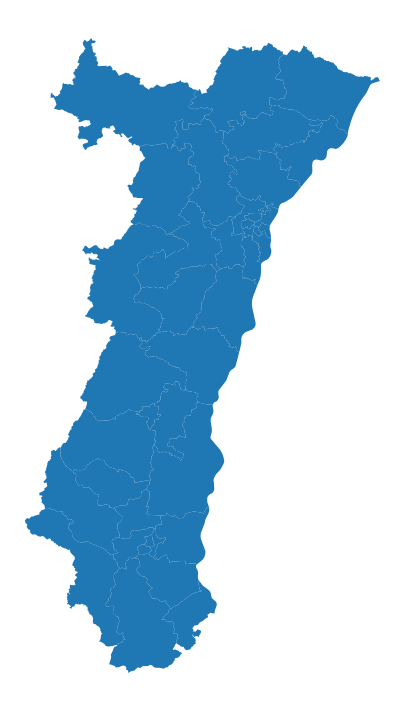

In [32]:
fig,ax=plt.subplots(figsize=(7,14))

alsace.plot(ax=ax)
ax.axis("off");

C'est encore une fois conforme, mais incomplet. Il est temps de **récupérer les infos qui nous intéressent et de les ajouter à cette GeoDataFrame**.

# Aspirer nuances et listes de candidats

## Côté nuances

Dans ce type travail, les couleurs peuvent vite se révéler être un casse-tête. C'est une question passionnante, capable d'alimenter [des débats réguliers](https://www.nouvelobs.com/rue89/rue89-politique/20151207.RUE1561/le-fn-il-est-plus-noir-profond-bleu-fonce-ou-violet.html).

Comme ce calepin n'a pas vocation à faire de la sémiologie, on commencera par la conclusion : utiliser les nuanciers de Wikipedia.

![nuancier_wikipedia](nuancier_wikipedia.png)

Pour ce faire, rien de tel que d'utiliser [la bibliothèque BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/). Comme Wikipedia est un site très (et bien) structuré, on va pouvoir interroger le tableau HTML qui nous intéresse, le parcourir et retenir ce qui nous préoccupe, à savoir :
* une étiquette, un peu purgée (BC-LR deviendra LR)
* une couleur

Bonne habitude oblige, on va aussi coder une petite fonction qui va resservir très vite :

In [33]:
nuancier_2021 ={}

pw=requests.get(r"https://fr.wikipedia.org/wiki/Répertoire_national_des_élus")
soupe = BeautifulSoup(pw.text, "lxml")
l_nuances = soupe.findAll("table", {"class":"wikitable"})[0]
lignes = l_nuances.findAll("tr")[2:]
for ligne in lignes:
    infos=ligne.findAll("td")
    if infos[3] and ("Candidat" not in str(infos[3].get_text())):
        nuancier_2021[infos[3].get_text().rstrip()[3:]]=infos[0].get("bgcolor")

def purge_dico(dico):
    # on va ranger les clés du dico à virer dans une liste
    # les clés correspondront à des valeurs nulles
    cles_purge=[]
    for v in dico.items():
        if v[1]==None:
            cles_purge.append(v[0])
    # on purge
    for cle in cles_purge:
       dico.pop(cle,None)
    # et on sert
    return dico

nuancier_2021=purge_dico(nuancier_2021)
nuancier_2021

{'EXG': '#bb0000',
 'COM': '#dd0000',
 'FI': '#cc2443',
 'SOC': '#FF8080',
 'RDG': '#ffd1dc',
 'DVG': '#ffc0c0',
 'ECO': '#77ff77',
 'DIV': '#eeeeee',
 'REG': '#DCBFA3',
 'GJ': '#FFFF00',
 'REM': '#ffeb00',
 'MDM': '#ff9900',
 'DVC': '#FAC577',
 'UDI': '#00FFFF',
 'LR': '#0066CC',
 'DSV': '#8040C0',
 'DVD': '#adc1fd',
 'RN': '#0D378A',
 'EXD': '#404040'}

Ce dictionnaire, aussi appelé *el famoso objet JavaScript*, sera copié/collé tel quel en variable dans le script de la carte.

Pourquoi s'arrêter en si bon chemin ? **On va aussi aspirer le nuancier des élections de 2015**, bien pratique pour colorier les cantons :

In [34]:
nuancier ={}

pw=requests.get(r"https://fr.wikipedia.org/wiki/Répertoire_national_des_élus")
soupe = BeautifulSoup(pw.text, "lxml")
l_nuances = soupe.findAll("table", {"class":"wikitable"})[5]
lignes = l_nuances.findAll("tr")[1:]
for ligne in lignes:
    infos=ligne.findAll("td")
    if infos[2]:
        nuancier[infos[1].get_text().rstrip()]=infos[0].get("bgcolor")

nuancier=purge_dico(nuancier)
nuancier

{'BC-EXG': '#bb0000',
 'BC-FG': '#dd0000',
 'BC-PG': '#cc2443',
 'BC-COM': '#dd0000',
 'BC-SOC': '#FF8080',
 'BC-UG': '#ffc6d5',
 'BC-RDG': '#ffd1dc',
 'BC-VEC': '#00c000',
 'BC-DIV': '#eeeeee',
 'BC-MDM': '#ff9900',
 'BC-UC': '#ffed99',
 'BC-UDI': '#00FFFF',
 'BC-UMP': '#0066cc',
 'BC-UD': '#b9daff',
 'BC-DLF': '#0082C4',
 'BC-DVD': '#adc1fd',
 'BC-FN': '#0D378A',
 'BC-EXD': '#404040'}

## Côté candidats

On va maintenant se pencher sur les candidats, et entamer doucement avec les sortants.

La recette, en bref :
* créer une **DataFrame vide**
* parcourir différentes pages HTML sur le site du Ministère de l'Intérieur. Les URL sont bien faites pour ça, **puisqu'elles sont différenciées par département et id de canton** (deux infos que nous avons dans la GeoDataFrame alsace)
* récupérer dans le tableau dédié des éléments de la première ligne (puisqu'après ce ne sont plus les vainqueurs)
* nettoyer tout ça
* **ajouter les infos** dans une nouvelle ligne de la DataFrame

In [35]:
sortants=pd.DataFrame(columns=["id","sortants","etiquette_sortants"])

def nettoyage_html(s):
    s=s.replace('<td style="text-align:center">',"")
    s=s.title()
    s=s.replace('<Td>',"")
    s=s.replace('</Td>',"")
    s=s.replace('<Br/>'," et ")
    s=s.replace('M. ',"")
    s=s.replace('Mme ',"")
    return s

for circ in alsace["id"]:
    s=r"https://www.interieur.gouv.fr/Elections/Les-resultats/Departementales/elecresult__departementales-2015/(path)/departementales-2015/0"+circ[:2]+"/0"+circ+".html"
    url = requests.get(s)
    soupe = BeautifulSoup(url.text, "lxml")
    tableau=soupe.find("table", {"class":"table table-bordered tableau-resultats-listes"})
    lignes=tableau.findAll("tr")[1:2]
    for ligne in lignes:
        cellules=ligne.findAll("td")
        binome=nettoyage_html(str(cellules[0]))
        sortants = sortants.append({"id":circ,"sortants":binome,"etiquette_sortants":cellules[1].get_text()}, ignore_index = True)
        
sortants.head()

,id,sortants,etiquette_sortants
0,6716,Marcel Bauer et Catherine Greigert,BC-UMP
1,6719,Françoise Bey et Serge Oehler,BC-SOC
2,6717,Mathieu Cahn et Suzanne Kempf,BC-SOC
3,6709,Catherine Graef-Eckert et Sébastien Zaegel,BC-UMP
4,6702,Etienne Burger et Marie-Paule Lehmann,BC-UMP


Un binôme par canton, cela implique qu'on va pouvoir fusionner cette DF sortants avec alsace, en considérant id comme champ commun.

Traduit en langage pandas :

In [36]:
alsace=alsace.merge(sortants,on="id")
alsace.head()

,id,nom,geometry,sortants,etiquette_sortants
0,6716,Sélestat,"POLYGON ((7.47694 48.20353, 7.47648 48.20364, ...",Marcel Bauer et Catherine Greigert,BC-UMP
1,6719,Strasbourg-3,"POLYGON ((7.68805 48.59813, 7.68795 48.59905, ...",Françoise Bey et Serge Oehler,BC-SOC
2,6717,Strasbourg-1,"POLYGON ((7.74370 48.58537, 7.74604 48.58658, ...",Mathieu Cahn et Suzanne Kempf,BC-SOC
3,6709,Lingolsheim,"POLYGON ((7.60233 48.55339, 7.60115 48.55327, ...",Catherine Graef-Eckert et Sébastien Zaegel,BC-UMP
4,6702,Bouxwiller,"POLYGON ((7.51059 48.74402, 7.51031 48.74394, ...",Etienne Burger et Marie-Paule Lehmann,BC-UMP


A présent, le gros morceau avec les binômes de cette année... Ce coup-ci on va avoir plusieurs duos par canton, et donc l'id du canton seul ne suffira pas.

On va donc créer dans une nouvelle DF **une colonne id_binome**, qui mixe l'identifiant du canton avec la place du binôme dans la liste de candidats. 

On va aussi **séparer chaque membre du binôme**, **en prévision de l'ajout d'informations** récoltées par les copains de Rue89 S :

In [37]:
candidats=pd.DataFrame(columns=["id","id_binome","nuance","b1","b2"])

for circ in alsace["id"]:
    canton=circ
    s="https://elections.interieur.gouv.fr/departementales-2021/CEA/C1CEA"+circ+".html"
    url = requests.get(s)
    soupe = BeautifulSoup(url.text, "lxml")
    lcandidats = soupe.find("table", {"class":"table table-bordered tableau-listes"})
    lignes = lcandidats.findAll("tr")[1:]
    for i,ligne in enumerate(lignes):
        infos=ligne.findAll("td")
        binome=nettoyage_html(str(infos[0]))
        binome=binome.split(" et ")
        nuance=str(infos[1].get_text()).replace("BC-","")
        candidats=candidats.append({"id":circ,"id_binome":str(circ)+str(i+1).rjust(2, "0"),"nuance":nuance,"b1":nettoyage_html(binome[0]),"b2":binome[1]}, ignore_index = True)

candidats.head()

,id,id_binome,nuance,b1,b2
0,6716,671601,RN,Eliane Klein,Philippe Nesz
1,6716,671602,UD,Catherine Greigert,Charles Sitzenstuhl
2,6716,671603,UGE,Chedlia Ben Salah-Breigeat,Bertrand Gaudin
3,6716,671604,DVC,Muriel Braun,Denis Digel
4,6716,671605,REG,Judith Eisele,Thiebault-Valery Zitvogel


Il est temps de passer au formulaire, téléchargé en csv. Nouveau fichier, nouvelle DataFrame :

In [38]:
formulaire=pd.read_csv("formulaire_candidats.csv")
formulaire.head()

,id,id_binome,canton,candidat 1,candidat 2,b1_naissance,b2_naissance,b1_age,b2_age,b1_sortant,b2_sortant,mandat_b1,mandat_b2,b1_profession,b2_profession,b1_photo,b2_photo,etiquette,b1_etiquette,b2_etiquette
0,6701,670101,Bischwiller,Mme SCHAEFFER Colette,M. ZINGRAFF Nicolas,01/01/1962,01/01/1985,59.0,36.0,non,non,non,non,Infirmière,Agent de sécurité,670101a.jpg,670101b.jpg,RN,RN,RN
1,6701,670102,Bischwiller,M. HOMMEL Denis,Mme THOMAS Nicole,NaN,NaN,NaN,NaN,oui,oui,NaN,NaN,NaN,NaN,NaN,NaN,LR,LR,LR
2,6701,670103,Bischwiller,Mme ISSELÉ Christelle,M. LORENTZ Michel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DVC,DVC,DVC
3,6702,670201,Bouxwiller,M. BURGER Etienne,Mme LEHMANN Marie-Paule,NaN,NaN,NaN,NaN,oui,oui,NaN,NaN,NaN,NaN,NaN,NaN,LR,DVD,LR
4,6702,670202,Bouxwiller,Mme SCHAERER Céline,M. WAGNER Jacky,18/07/1975,24/05/1961,45.0,60.0,non,non,non,Maire de Quatzenheim,Educatrice Spécialisée,Retraité - Maire,670202a.jpg,670202b.jpg,DVG,PCF,ÉCO


Avant d'enrichir la DF candidats, **on va nettoyer un peu le formulaire**. Cela va notammer se passer par :
* le remplissage de valeurs nulles (côté photos, on va mettre une silhouette générique)
* du remplacement de valeurs
* du complément de valeurs

Ingrat, mais nécessaire !

In [39]:
formulaire["b1_photo"].fillna("silhouette.jpg",inplace=True)
formulaire["b2_photo"].fillna("silhouette.jpg",inplace=True)
formulaire["b1_age"]=formulaire["b1_age"].astype(str)+" ans"
formulaire["b1_age"]=formulaire["b1_age"].str.slice(0,2)+formulaire["b1_age"].str.slice(4)
formulaire["b2_age"]=formulaire["b2_age"].astype(str)+" ans"
formulaire["b2_age"]=formulaire["b2_age"].str.slice(0,2)+formulaire["b2_age"].str.slice(4)
formulaire["mandat_b1"]=formulaire["mandat_b1"].str.replace("non"," Aucun mandat en cours")
formulaire["mandat_b2"]=formulaire["mandat_b2"].str.replace("non"," Aucun mandat en cours")
formulaire["b1_photo"]="images/"+formulaire["b1_photo"]
formulaire["b2_photo"]="images/"+formulaire["b2_photo"]
formulaire["id_binome"]=formulaire["id_binome"].astype(str)
formulaire.head()

,id,id_binome,canton,candidat 1,candidat 2,b1_naissance,b2_naissance,b1_age,b2_age,b1_sortant,b2_sortant,mandat_b1,mandat_b2,b1_profession,b2_profession,b1_photo,b2_photo,etiquette,b1_etiquette,b2_etiquette
0,6701,670101,Bischwiller,Mme SCHAEFFER Colette,M. ZINGRAFF Nicolas,01/01/1962,01/01/1985,59 ans,36 ans,non,non,Aucun mandat en cours,Aucun mandat en cours,Infirmière,Agent de sécurité,images/670101a.jpg,images/670101b.jpg,RN,RN,RN
1,6701,670102,Bischwiller,M. HOMMEL Denis,Mme THOMAS Nicole,NaN,NaN,naans,naans,oui,oui,NaN,NaN,NaN,NaN,images/silhouette.jpg,images/silhouette.jpg,LR,LR,LR
2,6701,670103,Bischwiller,Mme ISSELÉ Christelle,M. LORENTZ Michel,NaN,NaN,naans,naans,NaN,NaN,NaN,NaN,NaN,NaN,images/silhouette.jpg,images/silhouette.jpg,DVC,DVC,DVC
3,6702,670201,Bouxwiller,M. BURGER Etienne,Mme LEHMANN Marie-Paule,NaN,NaN,naans,naans,oui,oui,NaN,NaN,NaN,NaN,images/silhouette.jpg,images/silhouette.jpg,LR,DVD,LR
4,6702,670202,Bouxwiller,Mme SCHAERER Céline,M. WAGNER Jacky,18/07/1975,24/05/1961,45 ans,60 ans,non,non,Aucun mandat en cours,Maire de Quatzenheim,Educatrice Spécialisée,Retraité - Maire,images/670202a.jpg,images/670202b.jpg,DVG,PCF,ÉCO


Ultime nettoyage en virant quelques colonnes et en s'occupant des NaN restants :

In [40]:
formulaire.drop(columns=["etiquette","candidat 1","candidat 2","canton"],inplace=True)
formulaire["b1_age"]=formulaire["b1_age"].str.replace("naans", " ")
formulaire["b2_age"]=formulaire["b2_age"].str.replace("naans", " ")
formulaire.fillna(" ", inplace=True)
formulaire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             181 non-null    int64 
 1   id_binome      181 non-null    object
 2   b1_naissance   181 non-null    object
 3   b2_naissance   181 non-null    object
 4   b1_age         181 non-null    object
 5   b2_age         181 non-null    object
 6   b1_sortant     181 non-null    object
 7   b2_sortant     181 non-null    object
 8   mandat_b1      181 non-null    object
 9   mandat_b2      181 non-null    object
 10  b1_profession  181 non-null    object
 11  b2_profession  181 non-null    object
 12  b1_photo       181 non-null    object
 13  b2_photo       181 non-null    object
 14  b1_etiquette   181 non-null    object
 15  b2_etiquette   181 non-null    object
dtypes: int64(1), object(15)
memory usage: 22.8+ KB


Il est temps de fusionner ce formulaire avec la DF candidats :

In [41]:
candidats=candidats.merge(formulaire,on="id_binome")
candidats.drop(columns=["id_y"], inplace=True)
candidats.rename(columns={"id_x":"id"}, inplace=True)
candidats.head()

,id,id_binome,nuance,b1,b2,b1_naissance,b2_naissance,b1_age,b2_age,b1_sortant,b2_sortant,mandat_b1,mandat_b2,b1_profession,b2_profession,b1_photo,b2_photo,b1_etiquette,b2_etiquette
0,6716,671601,RN,Eliane Klein,Philippe Nesz,01/01/1959,01/01/1953,62 ans,68 ans,non,non,Aucun mandat en cours,Aucun mandat en cours,Kinésithérapeute,Retraité,images/671601a.jpg,images/671601b.jpg,RN,RN
1,6716,671602,UD,Catherine Greigert,Charles Sitzenstuhl,,,,,oui,non,,"Conseiller municipal de Selestat, conseiller r...",,,images/silhouette.jpg,images/silhouette.jpg,DVD,LREM
2,6716,671603,UGE,Chedlia Ben Salah-Breigeat,Bertrand Gaudin,07/12/1964,19/08/1976,56 ans,44 ans,non,non,Aucun mandat en cours,"Conseiller municipal de Selestat, conseiller c...",Professeure de Mathématiques,Directeur d'école,images/671603a.jpg,images/671603b.jpg,PCF,LREM
3,6716,671604,DVC,Muriel Braun,Denis Digel,,,,,,,,,,,images/silhouette.jpg,images/silhouette.jpg,DVC,DVC
4,6716,671605,REG,Judith Eisele,Thiebault-Valery Zitvogel,07/11/1980,13/04/1973,40 ans,48 ans,non,non,Aucun mandat en cours,Aucun mandat en cours,Employée à l’hôpital de Hautepierre et artisan...,"Enseignant d’Histoire- Géographie en lycée, an...",images/671605a.jpg,images/671605b.jpg,USL,USL


Que faire à partir de là ? On va [se servir de groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html), **l'une des fonctions les plus puissantes de pandas**.

Le principe :
* **choisir une ou plusieurs colonnes de regroupement**. Si on sélectionne la colonne id seule, la fonction va mixer les id identiques entre eux
* choisir une ou plusieurs colonnes de destination, **ainsi qu'une fonction à leur appliquer**. Exemple : j'ai tous les élèves de 6e, 5e, 4e et 3e de chaque département et je souhaite avoir le nombre total d'élèves au collège d'un département ? Solution : groupby sur le département, en faisant la somme de la colonne chiffrée
* il y a **plusieurs fonctions de regroupement** prévues par pandas, qui impliquent en général une perte d'informations (additionner tous les élèves fait perdre la classe), mais...
* on peut aussi coder sa propre fonction de regroupement, et l'appliquer [via la fort bien nommée apply()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html). 

Nouvel exemple : pour un canton donné, **on va établir une liste de dictionnaires**. Chaque dictionnaire va contenir les infos d'un binôme, comme renseignées dans la DF candidats. La longueur de chaque liste sera variable, mais on aura à l'arrivée :

* **un seul id** (correspondant au canton) 
* **une seule liste** (correspondant aux binômes de ce canton)

Une liste de dictionnaire Python se traduisant par el famoso tableau d'objets JavaScript, on est plutôt bien parti.

Il est maintenant temps de coder la fonction :

In [42]:
def dic_candidats(x):
    tab=[]
    for a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p in zip(x["id_binome"],x["nuance"], x["b1"], x["b2"], x["b1_age"],x["b2_age"], x["b1_sortant"], x["b2_sortant"], x["mandat_b1"], x["mandat_b2"], x["b1_profession"], x["b2_profession"], x["b1_photo"], x["b2_photo"],x["b1_etiquette"], x["b2_etiquette"]):
        dic={"id_binome":a,"nuance":b, "b1":c, "b2":d, "b1_age":e, "b2_age":f, "b1_sortant":g, "b2_sortant":h, "mandat_b1":i, "mandat_b2":j, "b1_profession":k, "b2_profession":l, "b1_photo":m, "b2_photo":n, "b1_etiquette":o, "b2_etiquette":p}
        tab.append(dic)
    return tab

Et de l'appliquer sur une nouvelle DF, lcandidats :

In [43]:
# d'abord, DF vide
lcandidats=pd.DataFrame(columns=["id","lcandidats"])
# ensuite, DF tampon
tampon=candidats.groupby(candidats["id"]).apply(dic_candidats)
# qu'on réimplante proprement dans la DF vide
lcandidats["id"]=tampon.index
lcandidats["lcandidats"]=tampon.values
lcandidats.head()

,id,lcandidats
0,6701,"[{'id_binome': '670101', 'nuance': 'RN', 'b1':..."
1,6702,"[{'id_binome': '670201', 'nuance': 'LR', 'b1':..."
2,6703,"[{'id_binome': '670301', 'nuance': 'RN', 'b1':..."
3,6704,"[{'id_binome': '670401', 'nuance': 'UGE', 'b1'..."
4,6705,"[{'id_binome': '670501', 'nuance': 'RN', 'b1':..."


On n'a plus qu'à enrichir notre GeoDataFrame du début, en utilisant le champ commun "id" :

In [44]:
alsace=alsace.merge(lcandidats,on="id")
# on doit convertir en str lcandidats pour éviter un plantage, ce qui ne la change pas en str pour autant... bref
alsace["lcandidats"]=alsace["lcandidats"].astype(str)
alsace.head()

,id,nom,geometry,sortants,etiquette_sortants,lcandidats
0,6716,Sélestat,"POLYGON ((7.47694 48.20353, 7.47648 48.20364, ...",Marcel Bauer et Catherine Greigert,BC-UMP,"[{'id_binome': '671601', 'nuance': 'RN', 'b1':..."
1,6719,Strasbourg-3,"POLYGON ((7.68805 48.59813, 7.68795 48.59905, ...",Françoise Bey et Serge Oehler,BC-SOC,"[{'id_binome': '671901', 'nuance': 'RN', 'b1':..."
2,6717,Strasbourg-1,"POLYGON ((7.74370 48.58537, 7.74604 48.58658, ...",Mathieu Cahn et Suzanne Kempf,BC-SOC,"[{'id_binome': '671701', 'nuance': 'DIV', 'b1'..."
3,6709,Lingolsheim,"POLYGON ((7.60233 48.55339, 7.60115 48.55327, ...",Catherine Graef-Eckert et Sébastien Zaegel,BC-UMP,"[{'id_binome': '670901', 'nuance': 'UGE', 'b1'..."
4,6702,Bouxwiller,"POLYGON ((7.51059 48.74402, 7.51031 48.74394, ...",Etienne Burger et Marie-Paule Lehmann,BC-UMP,"[{'id_binome': '670201', 'nuance': 'LR', 'b1':..."


Et on sert.

In [45]:
alsace.to_file("data/alsace.json", driver="GeoJSON")